<a href="https://colab.research.google.com/github/jamespan1118/Xenopus_signal_processing/blob/main/Wave_Envelope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import librosa
from librosa import display
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import signal
from scipy.io.wavfile import write
from scipy.ndimage import gaussian_filter1d
import pywt
import seaborn as sns
import statistics
import time

In [2]:
#checking runtime info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jul  8 18:42:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#checking RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
#loading the file
file_path = "/content/01-F818D-F8387-220616_0456_8min_selection (1)_female_filtered.wav"
samples, sampling_rate = librosa.load(file_path,sr=44100)

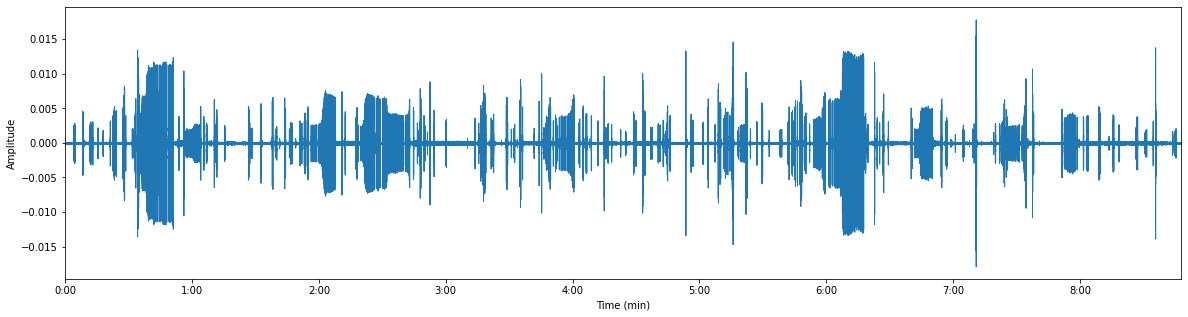

In [5]:
#plotting the audio data in time domain
plt.figure(figsize=(20,5))
librosa.display.waveplot(y=samples,sr=sampling_rate)
plt.xlabel("Time (min)")
plt.ylabel("Amplitude")
plt.show()

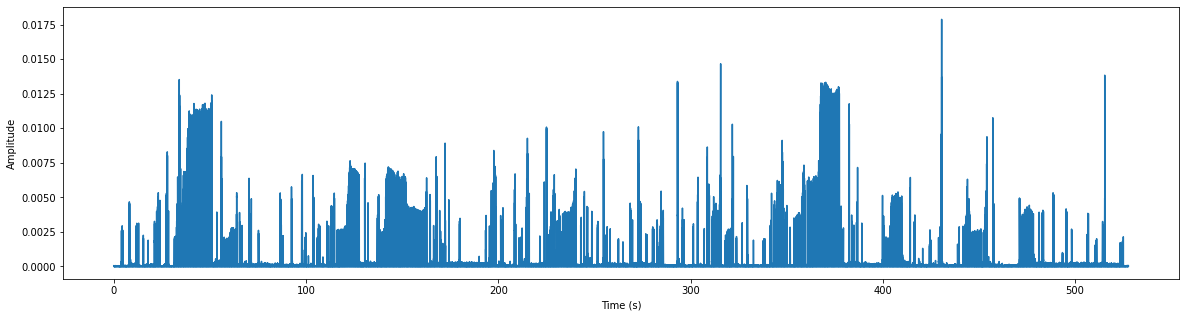

In [6]:
#getting all sample values into their absolute value
samples_abs = abs(samples)
plt.figure(figsize=(20,5))
duration = len(samples)/sampling_rate
x_time = np.arange(0,duration,1/sampling_rate) #time vector
plt.plot(x_time,samples_abs)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

##Using Hilbert transform to get the envelope

In [7]:
# hilbert transfrom envelope on raw data
start_time = time.time()
hilbert_signal = abs(signal.hilbert(samples))
end_time = time.time()
execution_time = end_time - start_time

In [ ]:
print("Execution time of Hilbert tranform for ",len(samples)," datapoints is: ",execution_time, " seconds")

Execution time of Hilbert tranform for  23274586  datapoints is:  15.409179925918579  seconds


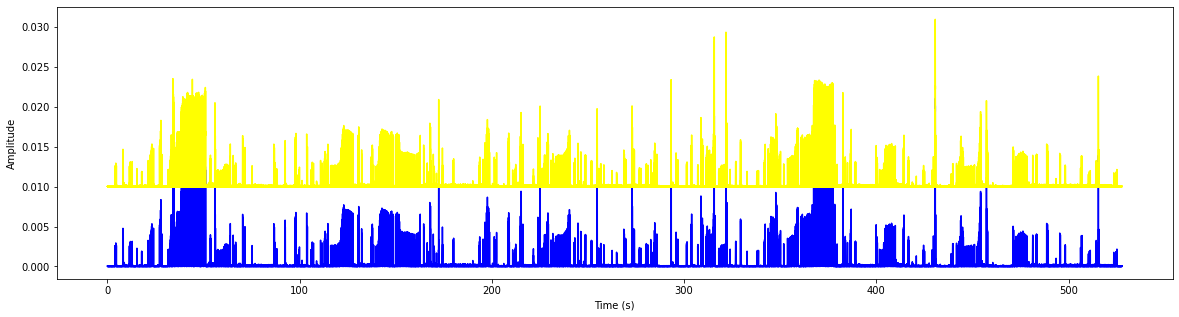

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(x_time,hilbert_signal,color = "blue")
plt.plot(x_time,samples_abs+0.01,color = "yellow")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
#find peaks using hilbert signal
#assumption: peaks of calling are at least 0.025 seconds apart
peaks, _  = scipy.signal.find_peaks(hilbert_signal,height=0.001,distance=0.025*44100)

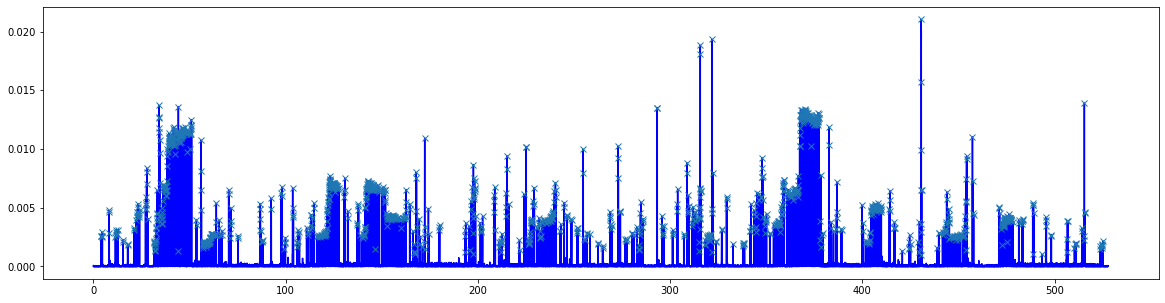

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(x_time,hilbert_signal,color = "blue")
plt.plot(x_time[peaks],hilbert_signal[peaks],'x')
#plt.xlim(4,5)
plt.show()

In [ ]:
#calculate inter-pulse interval
IPI = []
for i in range(0,len(peaks)-1):
  front = peaks[i]
  back = peaks[i+1]
  difference = x_time[back] - x_time[front]
  IPI.append(difference)

In [ ]:
#threshold is assumed to be 0.2
IPI_processed = []
i=0
while (i < (len(IPI)-3)):
  difference_1 = IPI[i]
  difference_2 = IPI[i+2] - IPI[i+1]
  if((IPI[i]<0.2)and(IPI[i+1]<0.2)):
    IPI_processed.append(IPI[i])
    IPI_processed.append(IPI[i+1])
    k = 2
    while(1):
      if(IPI[i+k]<0.2):
        IPI_processed.append(IPI[i+k])
        k=k+1
      else:
        i = i+k+1
        break
  else:
    i=i+1

Standard deviation of the XL Female calling: 0.032088196164091906
Standard deviation of the XL Female calling: 0.09139719980313477


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


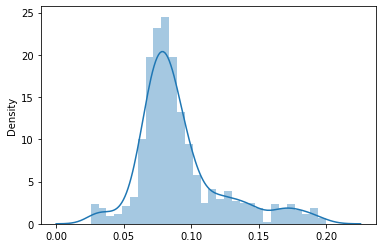

In [ ]:
sns.distplot(IPI_processed)
st_dev = statistics.pstdev(IPI_processed)
mean = statistics.mean(IPI_processed)
print("Standard deviation of the XL Female calling: " + str(st_dev))
print("Standard deviation of the XL Female calling: " + str(mean))

In [ ]:
len(IPI_processed)

751

##Using 1D CWT for feature extraction, then smoothing to extract envelope

In [7]:
# generate envelope using continous wavelet transform
scale = np.arange(70,110,10)
start_time = time.time()
coef, freqs=pywt.cwt(samples,scale,'morl')
end_time = time.time()
execution_time = end_time - start_time

In [8]:
print("Execution time of 1D CWT for ",len(samples)," datapoints is: ",execution_time, " seconds")

Execution time of 1D CWT for  23274586  datapoints is:  12.066541194915771  seconds


In [9]:
freqs.shape

(4,)

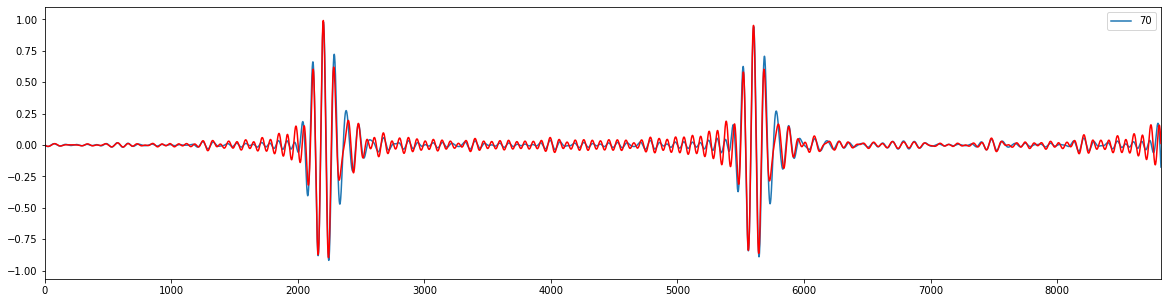

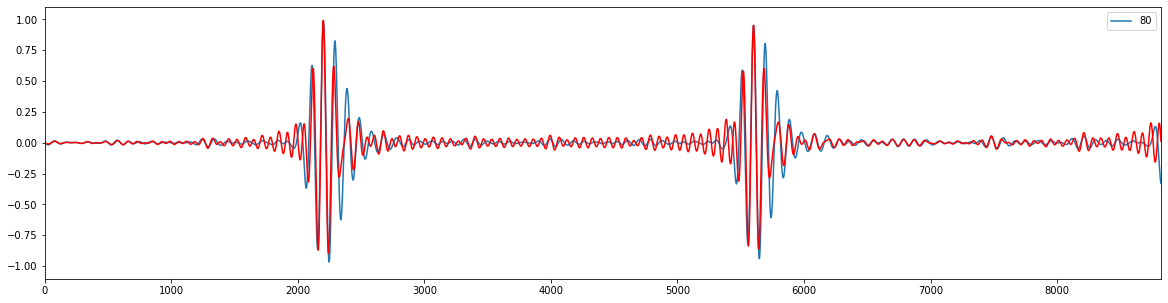

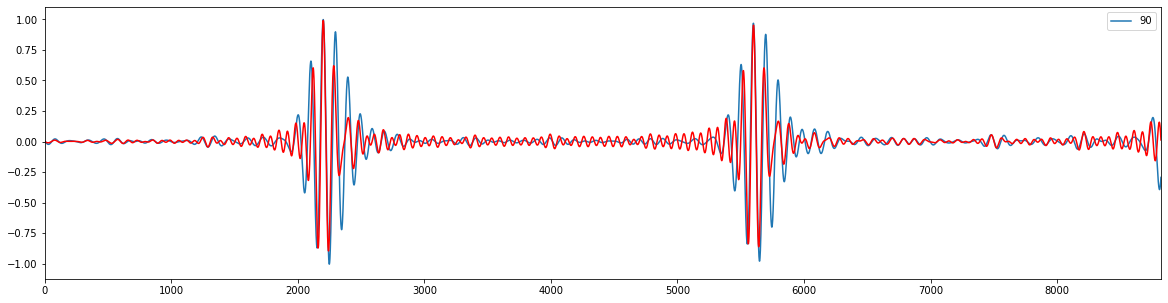

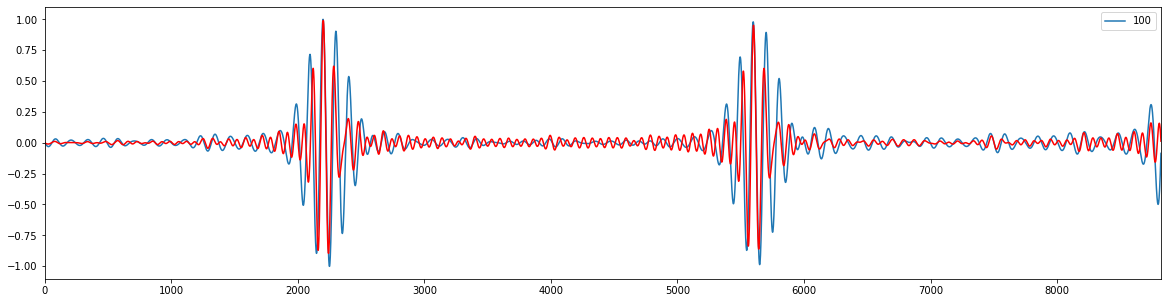

In [10]:
#experimental procedure to test which scale is the best for cwt
#zooming in on 40 - 41 s interval where there are female call
lbd = int(40*44100)
ubd = int(41*44100)
for i in range(0, len(coef)):
  plt.figure(figsize=(20,5))
  plt.plot((coef[i][lbd:ubd])/max(coef[i][lbd:ubd]),label=10*(i)+70)
  plt.xlim(0,44100*0.2)
  plt.plot(samples[lbd:ubd]/max(samples[lbd:ubd]),color="red")
  plt.legend()
  plt.show()

In [11]:
# found the scale = 90 to be a good parameter
scale = [90]
coef, freqs=pywt.cwt(samples,scale,'morl')

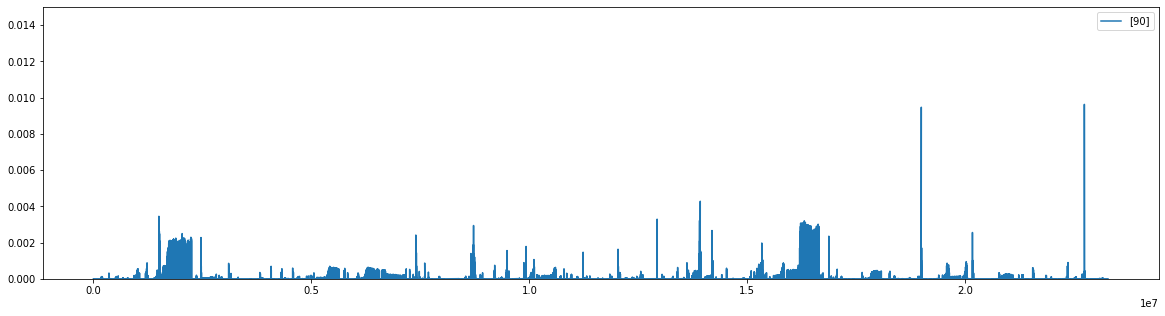

In [12]:
#increase the power of the wavelet transform result to faciliate the 
#extration of features
a=coef[0]**2
b = a[0::20]
plt.figure(figsize=(20,5))
plt.plot(a,label=scale)
#plt.xlim(0,44100*0.2)
plt.ylim(0,0.015)
plt.legend()
plt.show()

In [28]:
y_smoothed = gaussian_filter1d(a, 100)

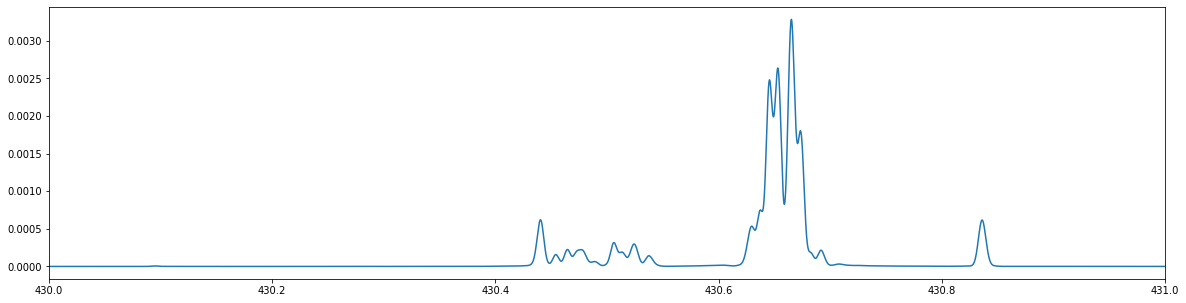

In [32]:
plt.figure(figsize=(20,5))
plt.plot(x_time,y_smoothed)
plt.xlim(430,431)
plt.show()

In [37]:
def noise_filter(noise_file,signal,sigma=100,sampling_rate=44100,peak_height=0.001):
  #load audio files
  samples_noise, sampling_rate = librosa.load(noise_file,sr=sampling_rate)
  #get noise peaks
  noise_smoothed = gaussian_filter1d(abs(samples_noise),sigma)
  noise_peaks, _ = scipy.signal.find_peaks(noise_smoothed,height=peak_height)
  #filtering
  for i in noise_peaks:
    signal[int(i-(sigma*10/2)):int(i+(sigma*10/2))]=0
  return signal

In [38]:
noise_filter('/content/01-F818D-F8387-220616_0456_8min_selection (1)_noise.wav',y_smoothed)

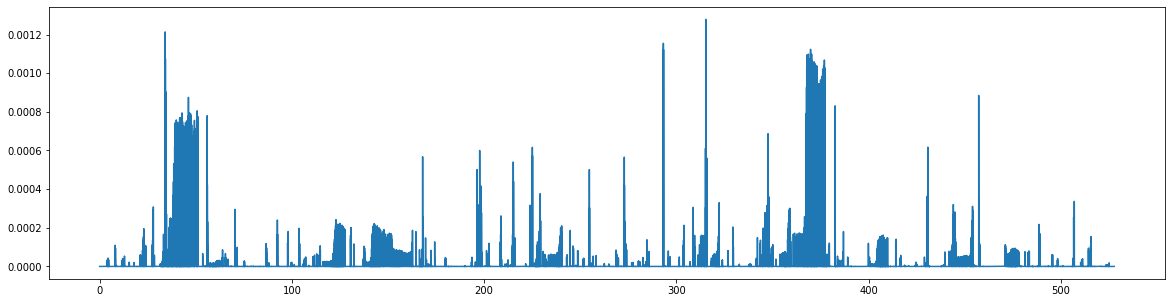

In [41]:
plt.figure(figsize=(20,5))
plt.plot(x_time,y_smoothed)
#plt.xlim(430,431)
plt.show()

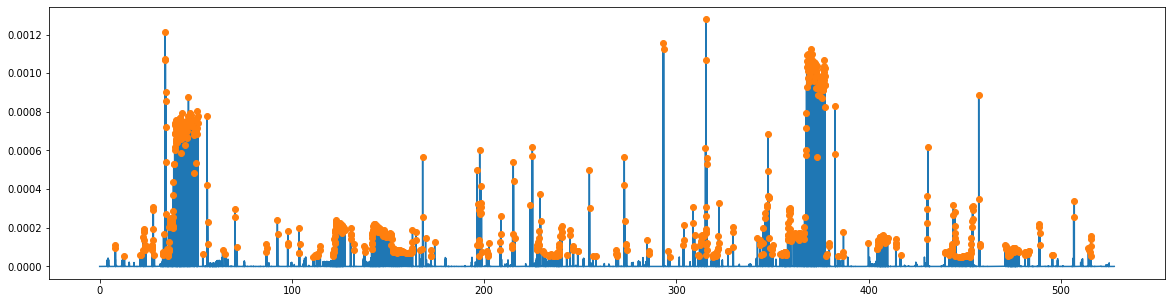

In [43]:
peaks,_ = signal.find_peaks(y_smoothed,height=0.00005)
plt.figure(figsize=(20,5))
plt.plot(x_time,y_smoothed)
plt.plot(x_time[peaks], y_smoothed[peaks], 'o')
#plt.xlim(40*44100, 41*44100)
plt.show()

In [44]:
len(peaks)

895